In [1]:
import ttvfast
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ttvfast import models


In [2]:
# df=pd.read_csv(r'/Users/sarahkubiak/Desktop/WD1856/test.txt', sep=' ')
df=pd.read_csv(r'/Users/sarahkubiak/Desktop/WD1856/newdatawithoutbadthings.txt', sep=' ')
df

brucetransittime=np.array(df['Time'])
#brucetransittime= 1.40794050*brucetransitnumber + 2458779.3750828
brucetransitnumber= np.round((brucetransittime-2458779.3750828)/1.40794050)
#brucex= brucetransitnumber
#brucey=np.array(df['dT[sec]'])
bruceerr= np.array(df['Uncertainty'])*60*60*24
#fig, ax = plt.subplots(figsize=(16, 8))

#plt.errorbar(brucex, brucey, yerr = bruceerr, fmt = 'o')
#ax.set_ylabel('seconds');
#ax.set_xlabel('transit number');

actualbrucetransittime = np.array(df['Time'])-2458700

transitswewant = (brucetransitnumber + 9)
transitswewant = (transitswewant.astype(int))
print(transitswewant)

[177 189 209 226 231 233 238 248 255 265   9 103 152 159 176]


In [3]:
def loglikelihood(p, actualbrucetransittime, bruceerr, yesplot= False): #here p is an array of the parameters: let's define p[0] = slope, and p[1] = intercept
    #slope = p[0]
    #intercept = p[1]
    #quad = p[2]
    #model = slope*x + intercept+ quad*x**2
    #chisq = np.sum((y - model)**2 / e**2)
    
    gravity =  0.000295994511                        # AU^3/day^2/M_sun
    stellar_mass = 0.518 #0.95573417954    #change me                # M_sun


    planet1 = models.Planet(
        mass = 0.00954588, #0.00002878248,                         # M_sun
        period = p[7],#1.4079405,#1.0917340278625494e+01,              # days
        eccentricity = 0,#5.6159310042858110e-02,
        inclination = 20,#88.778,#9.0921164935951211e+01,         # degrees
        longnode = -1.1729336712101943e-18,           # degrees
        argument = 1.8094838714599581e+02,            # degrees
        mean_anomaly = p[8],#-90 #-8.7093652691581923e+01,       # degrees
    )

    planet2 = models.Planet(
        mass = p[0],#0.00954588,#0.00061895914,
        period = p[1],#200,#1.4079405,#2.2266898036209028e+01,
        eccentricity = p[2],#0.7, #5.6691301931178648e-02,
        inclination = p[3],#8.7598285693573246e+01,
        longnode = p[4],#4.6220554014026838e-01,
        argument = p[5],#1.6437004273382669e+00,
        mean_anomaly = p[6],#-1.9584857031843157e+01,
    )

    planets = [planet1, planet2]
    Time = 66.70357200363651-1.4079405+0.003714472890699483 #-1045                                    # days
    dt = 0.02                                       # days
    Total = 510 #1700                                    # days

    results = ttvfast.ttvfast(planets, stellar_mass, Time, dt, Total)
    whichplanet = results["positions"][0]
    whichtransit = results["positions"][1]
    transittimes = results["positions"][2]
    planet1transits = []
    planet1times = []
    transittimesplanet0 = []
    transitnumberplanet0 = []
    for i in range(375):
        a = whichplanet[i]
        condition = a == 0  
        if condition: 
            transittimesplanet0.append(transittimes[i] )
            transitnumberplanet0.append(whichtransit[i] )
    
    
    if yesplot: 
        fig, ax = plt.subplots(figsize=(16, 8))
    #m=np.mean((actualbrucetransittime-1.4079405*brucetransitnumber)*24*60*60)
    #model data- model line 
    #plt.errorbar(brucetransitnumber, (actualbrucetransittime-1.4079405*brucetransitnumber)*24*60*60-m, yerr = bruceerr, fmt = 'o-', label = 'Data')
    #print(actualbrucetransittime)
    #print(np.array(transittimesplanet0)[transitswewant])
    #bruce data- model line 
    #plt.plot(brucetransitnumber, (np.array(transittimesplanet0)[transitswewant]-1.4079405*brucetransitnumber)*24*60*60-m,"o-", label = 'Model')
    #ax.set_ylabel('seconds');
    '''ax.set_xlabel('transit number');
    ax.set_title('mass = '+ str(p[0])+ ' period ='+ str(p[1]))
    plt.show()'''
    '''print(np.array(transittimesplanet0)[transitswewant[0:5]])
    print(actualbrucetransittime[0:5])'''
    pbruce = np.polyfit(brucetransitnumber,actualbrucetransittime,1, w= 1/bruceerr)
    pmodel = np.polyfit(brucetransitnumber,np.array(transittimesplanet0)[transitswewant],1,w= 1/bruceerr)
    brucetrend = np.polyval(pbruce,brucetransitnumber)
    modeltrend = np.polyval(pmodel,brucetransitnumber)
    brucetransittimecorrected = actualbrucetransittime - brucetrend
    modeltransittimecorrected = np.array(transittimesplanet0)[transitswewant] - modeltrend
    if yesplot:
        plt.errorbar(brucetransitnumber,brucetransittimecorrected*60*60*24, yerr = bruceerr, fmt = 'o-', label = 'Corrected Data')
        print(actualbrucetransittime)
        print(np.array(transittimesplanet0)[transitswewant])
        #bruce data- model line 
        plt.plot(brucetransitnumber, modeltransittimecorrected*60*60*24,"o-", label = 'Corrected Model')
        ax.set_ylabel('seconds');
        ax.set_xlabel('transit number');
        ax.set_title('mass = '+ str(p[0])+ ' period ='+ str(p[1])+ 'mean anomoly ='+ str(p[6])) 
        plt.show()
    chisq = np.sum((brucetransittimecorrected*60*60*24 - modeltransittimecorrected*60*60*24)**2/ bruceerr**2)
    #print(brucetransittimecorrected*60*60*24 - modeltransittimecorrected*60*60*24)
    #print(bruceerr)
    negloglikelihood = 0.5 * chisq
    return negloglikelihood

6.808982454326428e-07


<ipython-input-4-8181c946ab74>:18: RuntimeWarning: divide by zero encountered in log10
  im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')


NameError: name 'c' is not defined

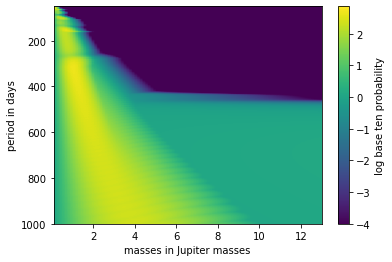

In [4]:
#Masses and Periods testing- New Data 
#periodstotest = np.linspace(50,1000,300)
#massestotest = np.linspace(0.1,13,100)/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('biggermassestotryfour.npz')
a = f["a"]
massestotest = f['massestotest']
periodstotest = f['periodstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('period in days')
ax.set_xlabel('masses in Jupiter masses')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)

In [ ]:
#Masses and Periods testing- New Data  
#periodstotest = np.linspace(50,200,100)
#massestotest = np.linspace(0.1,5,100)/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('biggermassestotrythree.npz')
a = f["a"]
massestotest = f['massestotest']
periodstotest = f['periodstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('period in days')
ax.set_xlabel('masses in Jupiter masses')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)

In [ ]:
#Masses and Periods testing- lol something is def wrong here, 
# this on is from when I was having issues with flipping the graph
#periodstotest = np.linspace(50,200,10)
#massestotest = np.linspace(0.1,100,10)/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('biggermassestotrytwwo.npz')
a = f["a"]
massestotest = f['massestotest']
periodstotest = f['periodstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('period in days')
ax.set_xlabel('masses in Jupiter masses')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)

In [ ]:
#Masses and Periods testing- Bruce Data 
#periodstotest = np.linspace(50,200,100)
#massestotest = np.linspace(0.1,100,100)/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('biggermassestotrytwo.npz')
a = f["a"]
massestotest = f['massestotest']
periodstotest = f['periodstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('period in days')
ax.set_xlabel('masses in Jupiter masses')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)

In [ ]:
#Ecentricities and Inclination testing- Bruce Data  
#ecentricitiestotest = np.linspace(0,0.7,100)
#inclinationstotest = np.linspace(0,90,100)#/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('bigecentricities.npz')
a = f["a"]
ecentricitiestotest = f['ecentricitiestotest']
inclinationstotest = f['inclinationstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('inclination in degrees')
ax.set_xlabel('ecentricity')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)

In [ ]:
#Ecentricition and Inclination testing- New Data  
#ecentricitiestotest = np.linspace(0,0.7,100)
#inclinationstotest = np.linspace(0,90,100)#/1047.572 #conversion from jupiter to solar masses
#meananomolytotest = np.linspace(0,360,100)

f=np.load('bigecentricitiestwo.npz')
a = f["a"]
ecentricitiestotest = f['ecentricitiestotest']
inclinationstotest = f['inclinationstotest']

noplanetlikihood=np.exp(loglikelihood([0,120,0,90,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               10,1.40795,-90],actualbrucetransittime , bruceerr, yesplot= False)*-1)
print(noplanetlikihood)
planetlikihood = np.exp(-1*np.min(a, axis= 2))

fig,ax= plt.subplots()
im=ax.imshow(np.maximum(np.log10(planetlikihood/noplanetlikihood), -4 ),extent = [min(massestotest)*1047.572, max(massestotest)*1047.572,max(periodstotest),min(periodstotest)], aspect='auto')

fig.colorbar(im, label = 'log base ten probability')
ax.set_ylabel('inclination in degrees')
ax.set_xlabel('ecentricity')


test=loglikelihood([massestotest[c],periodstotest[d],0.6,8.7598285693573246e+01,
                                               4.6220554014026838e-01,1.6437004273382669e+00,
                                               meananomolytotest[e],1.40795,-90],actualbrucetransittime , bruceerr, yesplot= True)
print(test)
print(noplanetlikihood)